<a href="https://colab.research.google.com/github/smslca/Huggigfaces/blob/main/Text_Classification_using_HuggingFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U transformers datasets umap-learn

In [2]:
from datasets import load_dataset

In [3]:
emotions = load_dataset("emotion")
emotions

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
train_ds.column_names

['text', 'label']

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [9]:
import pandas as pd
emotions.set_format("pandas")
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

df['label_str'] = df['label'].apply(label_int2str)

In [11]:
df.head()

,text,label,label_str
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


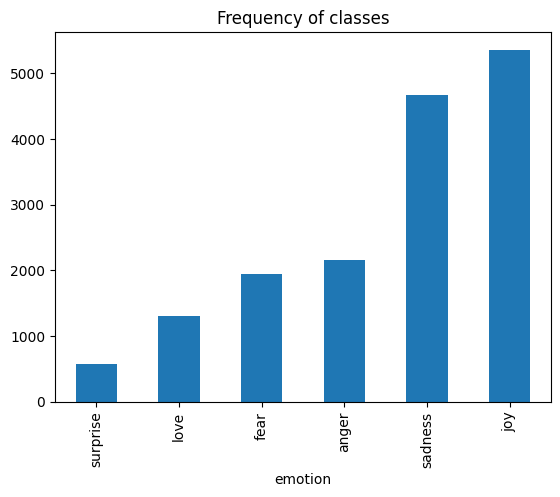

In [12]:
import matplotlib.pyplot as plt
df.label_str.value_counts(ascending=True).plot.bar()
plt.title('Frequency of classes')
plt.xlabel("emotion")
plt.show()

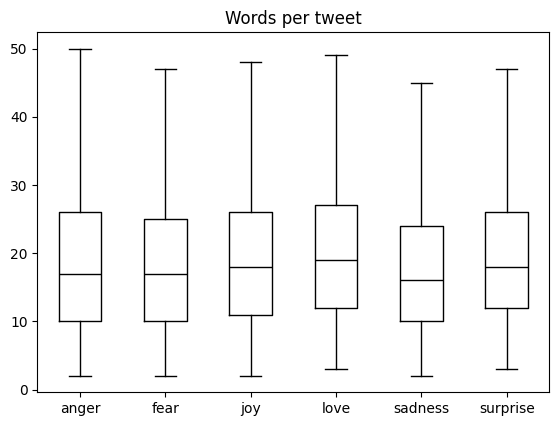

In [13]:
df['Words per tweet'] = df['text'].str.split(' ').apply(len)
df.boxplot("Words per tweet",by='label_str',grid=False,showfliers=False,color='black')
plt.suptitle("")
plt.xlabel("")
plt.show()

In [14]:
emotions.reset_format()

In [15]:
from transformers import AutoTokenizer
model_check_point = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_check_point)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [16]:
text = "Tokenizing text is a core task of NLP."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [18]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [19]:
tokenizer.convert_tokens_to_ids(tokens)

[101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102]

In [20]:
print(tokenizer.vocab_size)
print(tokenizer.model_max_length)
print(tokenizer.model_input_names)

30522
512
['input_ids', 'attention_mask']


In [21]:
def tokenize(batch):
  return tokenizer(batch['text'],padding=True,truncation=True)

In [22]:
tokenize(emotions['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [23]:
emotions_encoded = emotions.map(tokenize,batched=True,batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
emotions_encoded['train'][0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [25]:
print(emotions_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


In [26]:
from transformers import AutoModel
import torch
model_check_point = 'distilbert-base-uncased'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_check_point).to(device)

In [27]:

text = "this is a test"
inputs = tokenizer(text,return_tensors='pt')
print(f"Input tensors shape: {inputs['input_ids'].size()}")

Input tensors shape: torch.Size([1, 6])


In [28]:
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [29]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [30]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [31]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy() }

In [32]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask','label'])

In [33]:
emotions_hidden = emotions_encoded.map(extract_hidden_states,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [34]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [35]:
import numpy as np
X_train = np.array(emotions_hidden['train']['hidden_state'])
y_train = np.array(emotions_hidden['train']['label'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_valid = np.array(emotions_hidden['validation']['label'])
X_test  = np.array(emotions_hidden['test']['hidden_state'])
y_test  = np.array(emotions_hidden['test']['label'])
X_train.shape,X_valid.shape,X_test.shape

((16000, 768), (2000, 768), (2000, 768))

In [36]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train,y_train)
lr_clf.score(X_valid,y_valid)

0.633

In [37]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train,y_train)
dummy_clf.score(X_valid,y_valid)

0.352

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
def plot_confusion_matrix(y_preds,y_true,labels):
  cm = confusion_matrix(y_true,y_preds,normalize='true')
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
  disp.plot(cmap="Blues",values_format=".2f",ax=ax,colorbar=False)
  plt.title('Normalized Confusion Matrix')
  plt.show()



In [39]:
labels =  emotions['train'].features['label'].names
labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

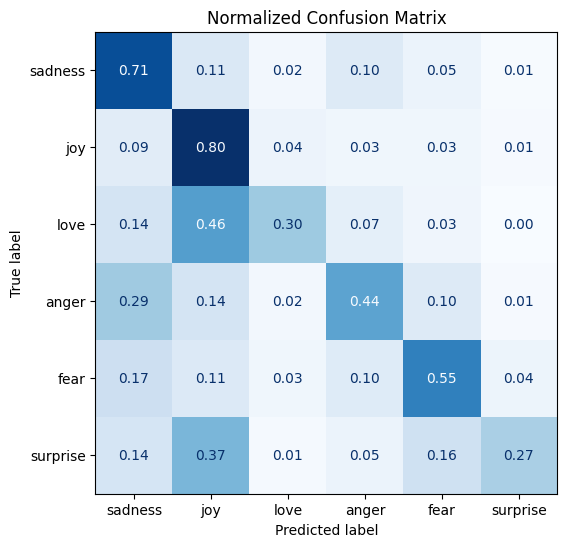

In [40]:
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds,y_valid,labels)

In [41]:
from transformers import AutoModelForSequenceClassification
import torch
num_labels = 6
model_check_point = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_check_point,num_labels=num_labels).to(device)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
from sklearn.metrics import f1_score,accuracy_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels,preds,average="weighted")
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1}

In [47]:
from huggingface_hub import notebook_login
notebook_login()

In [44]:
from transformers import Trainer, TrainingArguments

In [45]:
batch_size = 64
logging_steps = len(emotions_encoded['train'])//batch_size
model_name = f'{model_check_point}-praveen-emotions-finetuned'
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs = 2,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = 'epoch',
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level='error'
                                  )

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [49]:
trainer = Trainer(model=model,args=training_args,compute_metrics=compute_metrics,train_dataset = emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],tokenizer=tokenizer)
trainer.train()

<ipython-input-49-df59c234847c>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model,args=training_args,compute_metrics=compute_metrics,train_dataset = emotions_encoded['train'],


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.821300,0.315488,0.910500,0.909719
2,0.250100,0.216008,0.926500,0.926555


TrainOutput(global_step=500, training_loss=0.5356638641357422, metrics={'train_runtime': 240.8365, 'train_samples_per_second': 132.87, 'train_steps_per_second': 2.076, 'total_flos': 720342861696000.0, 'train_loss': 0.5356638641357422, 'epoch': 2.0})

In [50]:
preds_output = trainer.predict(emotions_encoded['validation'])

In [52]:
preds_output.metrics

{'test_loss': 0.21600763499736786,
 'test_accuracy': 0.9265,
 'test_f1': 0.9265545364611488,
 'test_runtime': 4.0272,
 'test_samples_per_second': 496.628,
 'test_steps_per_second': 7.946}

In [53]:
y_preds = np.argmax(preds_output.predictions,axis=1)

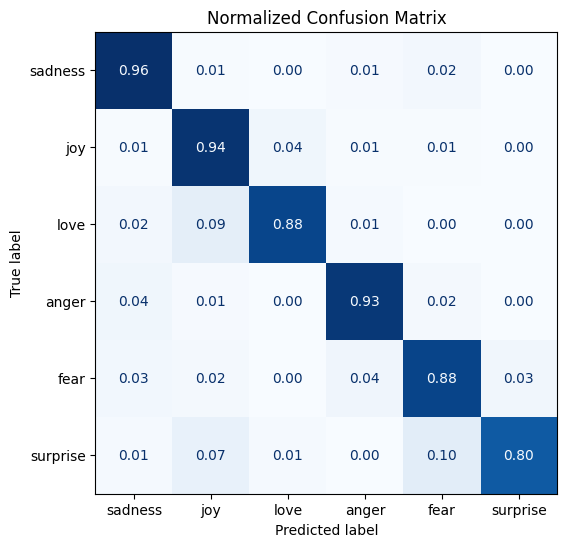

In [54]:
plot_confusion_matrix(y_preds,y_valid,labels)

In [56]:
from torch.nn.functional import cross_entropy

In [66]:
def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits,axis=-1)
    loss = cross_entropy(output.logits,batch['label'].to(device),reduction='none')
  return {"loss": loss.cpu().numpy(),
          "predicted_label":pred_label.cpu().numpy()}

In [67]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask','label'])
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_with_label,batched=True,batch_size=16)


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [68]:
emotions_encoded.set_format('pandas')
cols = ['text','label','predicted_label','loss']
df_test = emotions_encoded['validation'][:][cols]
df_test['label'] = df_test['label'].apply(label_int2str)
df_test['predicted_label'] = df_test['predicted_label'].apply(label_int2str)


In [69]:
df_test.sort_values("loss",ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.554619
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.528581
1274,i am going to several holiday parties and i ca...,joy,sadness,5.496263
765,i feel super awkward and out of place right now,joy,sadness,5.062374
177,im sure much of the advantage is psychological...,sadness,joy,4.934067
882,i feel badly about reneging on my commitment t...,love,sadness,4.843311
1950,i as representative of everything thats wrong ...,surprise,sadness,4.760840
1509,i guess this is a memoir so it feels like that...,joy,fear,4.721228
1801,i feel that he was being overshadowed by the s...,love,sadness,4.506675
1111,im lazy my characters fall into categories of ...,joy,fear,4.466952


In [70]:
trainer.push_to_hub(commit_message="Training Completed!!!")

events.out.tfevents.1734690889.123d41e486cf.2373.1:   0%|          | 0.00/6.82k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/smslca/distilbert-base-uncased-praveen-emotions-finetuned/commit/5bcd642b8c3aaa69d9e14d2fa75facbc6b7c9b4c', commit_message='Training Completed!!!', commit_description='', oid='5bcd642b8c3aaa69d9e14d2fa75facbc6b7c9b4c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/smslca/distilbert-base-uncased-praveen-emotions-finetuned', endpoint='https://huggingface.co', repo_type='model', repo_id='smslca/distilbert-base-uncased-praveen-emotions-finetuned'), pr_revision=None, pr_num=None)

In [71]:
from transformers import pipeline

In [72]:
model_id = 'smslca/distilbert-base-uncased-praveen-emotions-finetuned'
classifier = pipeline('text-classification',model=model_id)
tweet = "I saw a horrible movie today"
preds = classifier(tweet,return_all_scores=True)


config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


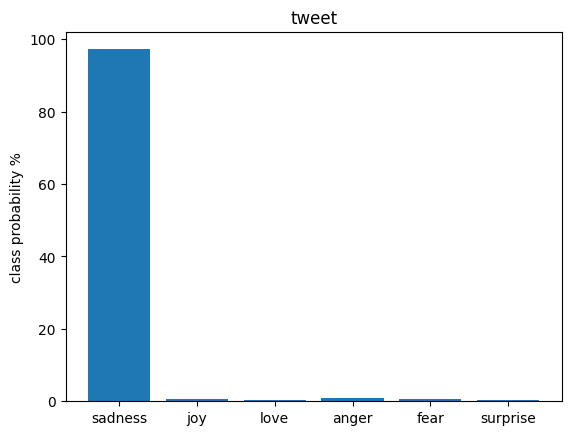

In [73]:
import pandas as pd
preds_df = pd.DataFrame(preds[0])
plt.bar(labels,100*preds_df['score'])
plt.title(f'tweet')
plt.ylabel('class probability %')
plt.show()